## Homework Assignment 9 - Version 2

**Question 1:** Select a short video with at least 3 animals and create a new movie from this video with a face tracker (each person’s face needs to be tracked by a rectangle of a different color) (50pt). See, for example, the video in: https://github.com/ageitgey/face_recognition

In [7]:
import numpy as np
import argparse
import imutils
import time
import cv2
import os

video = os.path.join("video.mp4")
conf=0.5
threshold = 0.3

# load the COCO class labels our YOLO model was trained on
labelsPath = os.path.sep.join(["coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")

# initialize a list of colors to represent each possible class label
COLORS = [
    (255, 0, 0),    # Red
    (0, 255, 0),    # Green
    (0, 0, 255),    # Blue
    (255, 255, 0),  # Yellow
    (255, 0, 255),  # Magenta
    (0, 255, 255),  # Cyan
    (255, 255, 255) # White
]

weightsPath = os.path.sep.join(["yolov3.weights"])
configPath = os.path.sep.join(["yolov3.cfg"])

print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

vs = cv2.VideoCapture(video)
writer = None
(W, H) = (None, None)

try:
    prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
        else cv2.CAP_PROP_FRAME_COUNT
    total = int(vs.get(prop))
    print("[INFO] {} total frames in video".format(total))

except:
    print("[INFO] could not determine # of frames in video")
    print("[INFO] no approx. completion time can be provided")
    total = -1

while True:
    (grabbed, frame) = vs.read()

    if not grabbed:
        break

    if W is None or H is None:
        (H, W) = frame.shape[:2]

    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
        swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    layerOutputs = net.forward(ln)
    end = time.time()

    boxes = []
    confidences = []
    classIDs = []

    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            if confidence > conf:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf, threshold)

    # ensure at least one detection exists
    if len(idxs) > 0:
        for i in idxs.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            color = COLORS[i % len(COLORS)]  # Choose color based on classID
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(frame, text, (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"MP4V")
        writer = cv2.VideoWriter("lio.mp4", fourcc, 30,
            (frame.shape[1], frame.shape[0]), True)

        if total > 0:
            elap = (end - start)
            print("[INFO] single frame took {:.4f} seconds".format(elap))
            print("[INFO] estimated total time to finish: {:.4f}".format(
                elap * total))

    writer.write(frame)

print("[INFO] cleaning up...")
writer.release()
vs.release()

[INFO] loading YOLO from disk...
[INFO] 625 total frames in video
[INFO] single frame took 1.7140 seconds
[INFO] estimated total time to finish: 1071.2811
[INFO] cleaning up...


In [8]:
from IPython.display import display, clear_output
import PIL.Image
from io import BytesIO
import IPython.display

cap = cv2.VideoCapture("lio.mp4")

while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break

    frame_pil = PIL.Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    clear_output(wait=True)
    display(frame_pil)
    time.sleep(0.03)  

cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

**Question 2:** Create an image classifier that can identify if a person in the image wears a has a beard (25pt). Create an image classifier that can identify if a person in the image wears an earing (20pt). Evaluate the classifier accuracy (5pt)

**Bonus:** use fastai to improve the results (10pt)

# Beard Classifier

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

df = pd.read_csv('data_facial_hair.csv')

file_paths = df['file'].tolist()
labels = df['type'].tolist()

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

input_shape = (500, 500, 3)  

model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

train_generator = train_datagen.flow_from_directory('train',
                                                    target_size=(500, 500),
                                                    batch_size=32,
                                                    class_mode='binary')

test_generator = test_datagen.flow_from_directory('validate',
                                                  target_size=(500, 500),
                                                  batch_size=32,
                                                  class_mode='binary')

model.fit(train_generator,
          steps_per_epoch=len(train_generator),
          epochs=10,
          validation_data=test_generator,
          validation_steps=len(test_generator))

Found 42 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Epoch 1/10
2/2 [==============================] - 60s 53s/step - loss: 16.5108 - accuracy: 0.4762 - val_loss: 1.2501 - val_accuracy: 0.6429
Epoch 2/10
2/2 [==============================] - 48s 41s/step - loss: 1.0597 - accuracy: 0.5000 - val_loss: 1.9859 - val_accuracy: 0.3571
Epoch 3/10
2/2 [==============================] - 49s 10s/step - loss: 1.3054 - accuracy: 0.5714 - val_loss: 0.6594 - val_accuracy: 0.6786
Epoch 4/10
2/2 [==============================] - 40s 34s/step - loss: 0.8090 - accuracy: 0.5000 - val_loss: 0.6741 - val_accuracy: 0.5000
Epoch 5/10
2/2 [==============================] - 51s 45s/step - loss: 0.6642 - accuracy: 0.5238 - val_loss: 0.6789 - val_accuracy: 0.5000
Epoch 6/10
2/2 [==============================] - 50s 11s/step - loss: 0.6363 - accuracy: 0.5714 - val_loss: 0.6849 - val_accuracy: 0.5357
Epoch 7/10
2/2 [==============================] - 45s 39s/step - loss: 0.6385 - accur

In [2]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_labels(file_paths):
    predicted_labels = []
    for file_path in file_paths:
        img = image.load_img(file_path, target_size=(500, 500)) 
        img = image.img_to_array(img)
        img = img / 255.0  
        img = np.expand_dims(img, axis=0)  
        prediction = model.predict(img)
        predicted_labels.append('beard' if prediction > 0.5 else 'no_beard')
    return predicted_labels

1/1 [==============================] - 0s 437ms/step


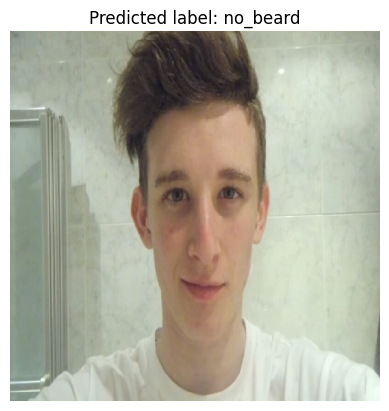

In [3]:
import matplotlib.pyplot as plt

image_path = 'test/3.jpg'

predicted_label = predict_labels([image_path])[0]

img = image.load_img(image_path, target_size=(500, 500))
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted label: {predicted_label}')
plt.show()

# Earrings Classifier

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

batch_size = 32
epochs = 10
IMG_HEIGHT = 150
IMG_WIDTH = 150

train_dir = "earring/train"
validation_dir = "earring/val"
test_dir = "earring/test"

train_image_generator = ImageDataGenerator(rescale=1./255) 
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size
)

test_loss, test_accuracy = model.evaluate(test_data_gen, verbose=2)
print('\nTest accuracy:', test_accuracy)

Found 2000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


C:\Users\kazom\AppData\Local\Temp\ipykernel_18420\1422415744.py:59: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
62/62 [==============================] - 45s 709ms/step - loss: 0.6998 - accuracy: 0.5910 - val_loss: 0.6097 - val_accuracy: 0.6562
Epoch 2/10
62/62 [==============================] - 31s 500ms/step - loss: 0.5673 - accuracy: 0.7027 - val_loss: 0.4900 - val_accuracy: 0.7396
Epoch 3/10
62/62 [==============================] - 31s 497ms/step - loss: 0.4780 - accuracy: 0.7708 - val_loss: 0.4348 - val_accuracy: 0.8073
Epoch 4/10
62/62 [==============================] - 30s 482ms/step - loss: 0.3879 - accuracy: 0.8257 - val_loss: 0.5977 - val_accuracy: 0.7396
Epoch 5/10
62/62 [==============================] - 31s 496ms/step - loss: 0.3350 - accuracy: 0.8506 - val_loss: 0.4559 - val_accuracy: 0.7760
Epoch 6/10
62/62 [==============================] - 30s 483ms/step - loss: 0.2421 - accuracy: 0.9035 - val_loss: 0.4587 - val_accuracy: 0.7708
Epoch 7/10
62/62 [==============================] - 31s 491ms/step - loss: 0.1594 - accuracy: 0.9355 - val_loss: 0.4354 - val_accuracy: 0.8177

1/1 [==============================] - 0s 31ms/step


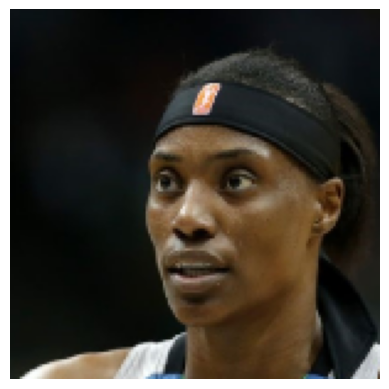

The person in the image is predicted not to wear earrings.


In [6]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

img_path = 'earring/val/plain/22-1.jpg' 
img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) 

predictions = model.predict(img_array)
class_index = 0 if predictions[0] < 0.5 else 1  

plt.imshow(img)
plt.axis('off')
plt.show()

if class_index == 0:
    print("The person in the image is predicted to wear earrings.")
else:
    print("The person in the image is predicted not to wear earrings.")